# 1. import

In [1]:
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, Sampler, DataLoader, Subset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# 커스텀 파이토치 데이터셋 / 모델 + 유틸 함수 import
from data_utils import *
from feature_eng import *

torch.manual_seed(12345)
random.seed(12345)
np.random.seed(12345)

# 2. 데이터 정보 + 상수 선언

In [2]:
aws_df = combine_df('./TRAIN_AWS/', './META/awsmap.csv')
pm_df = combine_df('./TRAIN/', './META/pmmap.csv')

## 2.1 기상 관측소 (AWS) 데이터

In [3]:
aws_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051920 entries, 0 to 35063
Data columns (total 10 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   연도         1051920 non-null  int64  
 1   일시         1051920 non-null  object 
 2   지점         1051920 non-null  object 
 3   기온(°C)     1032972 non-null  float64
 4   풍향(deg)    1032972 non-null  float64
 5   풍속(m/s)    1032972 non-null  float64
 6   강수량(mm)    1032972 non-null  float64
 7   습도(%)      1032972 non-null  float64
 8   Latitude   1051920 non-null  float64
 9   Longitude  1051920 non-null  float64
dtypes: float64(7), int64(1), object(2)
memory usage: 88.3+ MB


## 2.2 미세먼지 관측소 (PM) 데이터

In [4]:
pm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 596088 entries, 0 to 35063
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   연도         596088 non-null  int64  
 1   일시         596088 non-null  object 
 2   측정소        596088 non-null  object 
 3   PM2.5      580546 non-null  float64
 4   Latitude   596088 non-null  float64
 5   Longitude  596088 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 31.8+ MB


## 2. 3 상수 선언

In [5]:
num_aws = 30           # 총 기상 관측소 개수
num_pm = 17            # 총 미세먼지 관측소 개수
num_neighbors = 5      # 예측시 고려할 근처 관측소 개수
num_aws_features = 7   # 기상 특성 개수
num_pm_features = 8    # 기상 특성 + 미세먼지 특성 개수
num_timestamps = len(aws_df.groupby(['연도', '일시']).groups)

aws_dir = './TRAIN_AWS/'

# 3. AWS 예측 모델

## 3.1 전처리

In [6]:
# 위도 경도 정보 불러오기 + 위치 명 정수화 하기
region_encoder = OrdinalEncoder()
meta_df = pd.read_csv('./META/awsmap.csv')
meta_df['지점'] = meta_df['Location'].copy()
meta_df['Location'] = region_encoder.fit_transform(meta_df['지점'].to_frame())
meta_df = meta_df.iloc[:, :-2].sort_values(by='Location')
meta_df = pd.DataFrame(meta_df, index=meta_df['Location'], columns=['Latitude', 'Longitude'])

In [7]:
# 정수화된 지점 아이디와 지점 이름 매핑
regions = list(region_encoder.inverse_transform(np.array(range(30)).reshape(-1, 1)).flatten())
id_to_region = dict(zip(range(30), regions))
regions_to_id = dict(zip(regions, range(30)))

# 각 관측소 별 근처 5개의 관측소 구하기
neighbors = {}
for i in range(30):
    point = meta_df.iloc[i]
    temp = meta_df.copy()
    temp['Latitude'] -= point[0]
    temp['Longitude'] -= point[1]
    temp['dist'] = temp['Latitude'] ** 2 + temp['Longitude'] ** 2
    temp.sort_values(by='dist', inplace=True)
    neighbors[i] = [int(x) for x in temp.index[1:num_neighbors + 1]]

## 3.2 데이터 numpy array로 적제 후 PyTorch 데이터셋 생성하기

In [8]:
data = np.zeros((num_timestamps, num_aws, num_aws_features), float)
data[:, :, :] = np.nan

for i in range(30):
    aws_df = pd.read_csv(aws_dir + id_to_region[i] + '.csv')
    features = aws_df.values[:,3:]
    lat = meta_df.iloc[i, 0]
    long = meta_df.iloc[i, 1]
    data[:, i, :-2] = features
    data[:, i, -2:] = np.array([lat, long])

In [9]:
# 훈련셋 검증셋 나누기
dataset = AWSTrainDataset(data, num_aws=num_neighbors, time_size=10, neighbors=neighbors)
train_idx, valid_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=12345)
trainset, validset = Subset(dataset, train_idx), Subset(dataset, valid_idx)

## 3.3 AWS 모델 훈련

In [14]:
# 하이퍼 파라미터
num_lstm_out = 5
hidden_size = 20
time_size = 10
batch_size = 12
lr = 0.075
patience = 2
epochs = 30
steps_per_epoch = len(trainset) // batch_size // 10
valid_steps = len(validset) // batch_size // 10

# 데이터로더
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=NonNullSampler(trainset))
validloader = DataLoader(validset, batch_size=batch_size, sampler=NonNullSampler(validset))
train_iter = iter(trainloader)
valid_iter = iter(validloader)

# 모델 생성 
model = FeatureSeqNet(num_aws=num_neighbors, num_features=num_aws_features, time_size=time_size, hidden_size=hidden_size, num_lstm_out=num_lstm_out)
model.to(float)

# 옵티마이저, 스켸줄러, 손실함수 객체 생성
optimizer = optim.Adagrad(lr=lr, params=model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, mode='min', verbose=True)
loss_fn = nn.L1Loss()

# 훈련 결과 저장용
metrics = {'train':[], 'valid':[]}

In [15]:
# 훈련 루프
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for step in tqdm(range(steps_per_epoch), desc=f'Train epoch {epoch} ', ncols=100):
        inputs, targets = next(train_iter)
        output = model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= steps_per_epoch
    metrics['train'].append(train_loss)

    model.eval()
    val_loss = 0
    for step in tqdm(range(valid_steps), desc=f'Validation epoch {epoch} ', ncols=100):
        inputs, targets = next(valid_iter)
        output = model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        val_loss += loss.item()

    val_loss /= valid_steps
    metrics['valid'].append(val_loss)
    scheduler.step(val_loss)
    
    print(f'Metrics: Train Loss: {train_loss}, Valid Loss: {val_loss}')

Validation epoch 1 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 214.50it/s]


Metrics: Train Loss: 0.052684102519389556, Valid Loss: 0.04908011934810848


Validation epoch 2 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 214.17it/s]


Metrics: Train Loss: 0.04820054476888081, Valid Loss: 0.04784378194090744


Validation epoch 3 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 203.02it/s]


Metrics: Train Loss: 0.047643288137584436, Valid Loss: 0.04696283395532162


Validation epoch 4 : 100%|█████████████████████████████████████| 1752/1752 [00:10<00:00, 174.19it/s]


Metrics: Train Loss: 0.047388533992857085, Valid Loss: 0.04714507865860879


Validation epoch 5 : 100%|█████████████████████████████████████| 1752/1752 [00:09<00:00, 180.02it/s]


Metrics: Train Loss: 0.046976176394156244, Valid Loss: 0.04724141208544068


Validation epoch 6 : 100%|█████████████████████████████████████| 1752/1752 [00:07<00:00, 219.45it/s]


Metrics: Train Loss: 0.0469547323743288, Valid Loss: 0.04674176111460126


Validation epoch 7 : 100%|█████████████████████████████████████| 1752/1752 [00:07<00:00, 224.81it/s]


Metrics: Train Loss: 0.04681184905489146, Valid Loss: 0.046614858945416365


Validation epoch 8 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 213.25it/s]


Metrics: Train Loss: 0.04653187683921152, Valid Loss: 0.04654317038315111


Validation epoch 9 : 100%|█████████████████████████████████████| 1752/1752 [00:08<00:00, 218.35it/s]


Metrics: Train Loss: 0.04648367498108611, Valid Loss: 0.04651882348184977


Validation epoch 10 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 217.89it/s]


Metrics: Train Loss: 0.04632013831529437, Valid Loss: 0.04656064232184211


Validation epoch 11 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 214.39it/s]


Metrics: Train Loss: 0.04619382161215389, Valid Loss: 0.04638304721663339


Validation epoch 12 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 214.47it/s]


Metrics: Train Loss: 0.04617705459743926, Valid Loss: 0.04602640221726027


Validation epoch 13 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 215.64it/s]


Metrics: Train Loss: 0.04607227370340264, Valid Loss: 0.04595350297172826


Validation epoch 14 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 182.58it/s]


Metrics: Train Loss: 0.04597437359636996, Valid Loss: 0.04583577500198058


Validation epoch 15 : 100%|████████████████████████████████████| 1752/1752 [00:10<00:00, 172.02it/s]


Metrics: Train Loss: 0.04589409667554011, Valid Loss: 0.04625404555370381


Validation epoch 16 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 210.78it/s]


Metrics: Train Loss: 0.045908316151721695, Valid Loss: 0.046215117187399395


Validation epoch 17 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 194.49it/s]


Metrics: Train Loss: 0.04570358725342474, Valid Loss: 0.04553809456894562


Validation epoch 18 : 100%|████████████████████████████████████| 1752/1752 [00:08<00:00, 217.46it/s]


Metrics: Train Loss: 0.04567995942126298, Valid Loss: 0.045399801047251775


Validation epoch 19 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 177.58it/s]


Metrics: Train Loss: 0.0457069763286785, Valid Loss: 0.045841100833936874


Validation epoch 20 : 100%|████████████████████████████████████| 1752/1752 [00:09<00:00, 178.21it/s]


Metrics: Train Loss: 0.04558843486251431, Valid Loss: 0.04526609247627133


Validation epoch 21 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 229.28it/s]


Metrics: Train Loss: 0.04542982798768626, Valid Loss: 0.045581897996505624


Validation epoch 22 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 225.06it/s]


Metrics: Train Loss: 0.04554602494310286, Valid Loss: 0.04561308217628826


Validation epoch 23 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 224.22it/s]


Epoch 00023: reducing learning rate of group 0 to 7.5000e-03.
Metrics: Train Loss: 0.045467642745787566, Valid Loss: 0.045278252289755815


Validation epoch 24 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 225.25it/s]


Metrics: Train Loss: 0.04532785238172621, Valid Loss: 0.0456201273349513


Validation epoch 25 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 231.70it/s]


Metrics: Train Loss: 0.04532992746383057, Valid Loss: 0.04559117801849866


Validation epoch 26 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 228.56it/s]


Epoch 00026: reducing learning rate of group 0 to 7.5000e-04.
Metrics: Train Loss: 0.04527989870200146, Valid Loss: 0.0454048959226702


Validation epoch 27 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 222.98it/s]


Metrics: Train Loss: 0.04510254768653439, Valid Loss: 0.04521145930166926


Validation epoch 28 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 225.49it/s]


Metrics: Train Loss: 0.045142828604617505, Valid Loss: 0.045210753613354956


Validation epoch 29 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 226.18it/s]


Metrics: Train Loss: 0.04517194509644741, Valid Loss: 0.045404276479397446


Validation epoch 30 : 100%|████████████████████████████████████| 1752/1752 [00:07<00:00, 231.88it/s]

Metrics: Train Loss: 0.04507864373356155, Valid Loss: 0.04497438716788401


## 3.4 AWS 모델 훈련 시각화

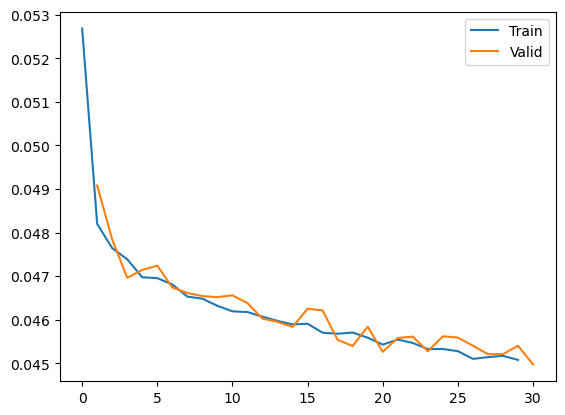

In [16]:
train_metrics = metrics['train']
val_metrics = metrics['valid']
plt.plot(range(len(train_metrics)), train_metrics, label='Train')
plt.plot(range(1, len(val_metrics) + 1), val_metrics, label='Valid')
plt.legend()
plt.show()

## 3.5 AWS 결측치 예측

In [17]:
# 시간 (index)과 관측소 (column)별로 측정값이 있는지 없는지 계산하여 DataFrame 형식으로 리턴
def null_time_intervals(root_dir, metadata_path, regions_to_id):
    dfs = []
    meta_df = pd.read_csv(metadata_path)
    for i in range(meta_df.shape[0]):
        csv_path = meta_df.iloc[i]['Location'] + '.csv'
        measure_df = pd.read_csv(root_dir + csv_path)
        null_datapoints = measure_df.isnull().sum(axis=1) > 0
        dfs.append(null_datapoints)
    result = pd.DataFrame()
    for i in range(meta_df.shape[0]):
        result[regions_to_id[meta_df.iloc[i]['Location']]] = dfs[i]
    return pd.DataFrame(result, columns=list(range(num_aws)))

# 결측값들의 (time_idx, aws_idx)의 리스트 만들기
null_times = null_time_intervals('./TRAIN_AWS/', './META/awsmap.csv', regions_to_id)
null_list = []
for time_idx in range(num_timestamps):
    for aws_idx in range(num_aws):
        if null_times.iloc[time_idx, aws_idx]:
            null_list.append((time_idx, aws_idx))

In [18]:
# 결측치 채우기
model.eval()
spatial_enc = model.spatial_encoder
seq_enc = model.sequential_encoder
decoder = model.decoder


data = dataset.data
for time_idx, aws_idx in null_list:
    inputs = torch.Tensor(dataset.get(time_idx, aws_idx))
    spatial_x = spatial_enc(inputs.unsqueeze(0).double())
    cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
    output, _ = decoder.lstm(cnn_out.repeat((1,1,2)).double())
    output = decoder.affine(torch.concat([cnn_out, output], dim=2).double()).flatten()
    if np.isnan(output.detach().numpy()).sum() > 0:
        raise Exception()
    data[time_idx, aws_idx, :-2] = output.detach().numpy()

## 3.6 AWS 모델 이용하여 PM 관측소의 기상정보 예측

In [19]:
# pm
pm_encoder = OrdinalEncoder()
pm_meta_df = pd.read_csv('./META/pmmap.csv')
pm_meta_df['측정소'] = pm_meta_df['Location'].copy()
pm_meta_df['Location'] = pm_encoder.fit_transform(pm_meta_df['측정소'].to_frame())
pm_meta_df = pm_meta_df.iloc[:, :-2].sort_values(by='Location')
pm_meta_df = pd.DataFrame(pm_meta_df, index=pm_meta_df['Location'], columns=['Latitude', 'Longitude'])

neighbors = {}
num_aws = 5
for i in range(17):
    point = pm_meta_df.iloc[i]
    temp = meta_df.copy()
    temp['Latitude'] -= point[0]
    temp['Longitude'] -= point[1]
    temp['dist'] = temp['Latitude'] ** 2 + temp['Longitude'] ** 2
    temp.sort_values(by='dist', inplace=True)
    neighbors[i] = [int(x) for x in temp.index[1:num_aws + 1]]

    ids = np.arange(17).reshape(-1, 1)
pms = pm_encoder.inverse_transform(ids).flatten()
pm_to_id = dict(zip(pms, ids.flatten()))
id_to_pm = dict(zip(ids.flatten(), pms))

In [20]:
pm_data = np.zeros((num_timestamps, 17, 7))
for time_idx in tqdm(range(10, num_timestamps), ncols=100):
    for pm_idx in range(17):
        pm_pos = list(pm_meta_df.iloc[pm_idx])
        inputs = torch.Tensor(dataset.get(time_idx, aws_idx))
        spatial_x = spatial_enc(inputs.unsqueeze(0).double())
        cnn_out = seq_enc(spatial_x).reshape(1, 1, -1)
        output, _ = decoder.lstm(cnn_out.repeat((1,1,2)).double())
        output = decoder.affine(torch.concat([cnn_out, output], dim=2).double()).flatten()
        if np.isnan(output.detach().numpy()).sum() > 0:
            raise Exception()
        pm_data[time_idx, pm_idx, :-2] = output.detach().numpy()
        pm_data[time_idx, pm_idx, -2:] = pm_pos

100%|█████████████████████████████████████████████████████████| 35054/35054 [10:58<00:00, 53.24it/s]


# 4. PM 예측 모델

## 4.1 PM 데이터 전처리

In [21]:
# 0번째 특성 PM2.5 추가
data = np.zeros((pm_data.shape[0], pm_data.shape[1], pm_data.shape[2] + 1))
data[:, :, 1:] = pm_data[:, :, :]
data[:10, :, 3] = np.nan
data[:, :, 0] = np.nan

for i in range(num_pm):
    df = pd.read_csv(f'./TRAIN/{id_to_pm[i]}.csv')
    for time_idx in range(data.shape[0]):
        data[time_idx, i, 0] = df.iloc[time_idx]['PM2.5']

In [22]:
pm_meta_df = pd.read_csv('./META/pmmap.csv')
pm_meta_df['측정소'] = pm_meta_df['Location'].copy()
pm_meta_df['Location'] = pm_encoder.transform(pm_meta_df['측정소'].to_frame())
pm_meta_df = pm_meta_df.iloc[:, :-2].sort_values(by='Location')
pm_meta_df = pd.DataFrame(pm_meta_df, index=pm_meta_df['Location'], columns=['Latitude', 'Longitude'])

neighbors = {}
num_aws = 5
for i in range(17):
    point = pm_meta_df.iloc[i]
    temp = pm_meta_df.copy()
    temp['Latitude'] -= point[0]
    temp['Longitude'] -= point[1]
    temp['dist'] = temp['Latitude'] ** 2 + temp['Longitude'] ** 2
    temp.sort_values(by='dist', inplace=True)
    neighbors[i] = [int(x) for x in temp.index[1:num_aws + 1]]

## 4.2 PyTorch 데이터셋 생성하기

In [23]:
dataset = PMTrainDataset(data, num_aws=num_neighbors, time_size=time_size, neighbors=neighbors)
train_idx, valid_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=12345)
trainset, validset = Subset(dataset, train_idx), Subset(dataset, valid_idx)
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=NonNullSampler(trainset))
validloader = DataLoader(validset, batch_size=batch_size, sampler=NonNullSampler(validset))

## 4.3 PM 모델 훈련

In [24]:
# 하이퍼파라미터
num_lstm_out = 6
lr = 0.05
patience = 2
epochs = 30
steps_per_epoch = len(trainset) // batch_size // 10
valid_steps = len(validset) // batch_size // 10

# 모델 생성
model = FeatureSeqNet(num_aws=num_neighbors, num_features=num_pm_features, time_size=time_size, hidden_size=hidden_size, num_lstm_out=num_lstm_out)
model.to(float)

# 옵티마이저, 스켸줄러, 손실함수 생성
optimizer = optim.Adagrad(lr=lr, params=model.parameters())
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=patience, mode='min', verbose=True)
loss_fn = nn.L1Loss()
train_iter = iter(trainloader)
valid_iter = iter(validloader)

# 훈련 결과 저장용
metrics = {'train':[], 'valid':[], 'pm mae':[]}

In [25]:
# 훈련 루프
for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0
    for step in tqdm(range(steps_per_epoch), desc=f'Train epoch {epoch} ', ncols=100):
        inputs, targets = next(train_iter)
        output = model(inputs, targets)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        optimizer.step()
        train_loss += loss.item()
    train_loss /= steps_per_epoch
    metrics['train'].append(train_loss)

    model.eval()
    val_loss = 0
    val_mae = 0
    for step in tqdm(range(valid_steps), desc=f'Validation epoch {epoch} ', ncols=100):
        inputs, targets = next(valid_iter)
        output = model(inputs, targets)
        pm_out = output[:, :, 0].view(-1)
        pm_target = targets[:, :, 0].view(-1)
        output = output.view(-1)
        targets = targets.view(-1)
        loss = loss_fn(output, targets)
        val_loss += loss.item()
        val_mae += loss_fn(pm_out, pm_target).item()

    val_loss /= valid_steps
    val_mae /= valid_steps
    metrics['valid'].append(val_loss)
    metrics['pm mae'].append(val_mae)
    scheduler.step(val_mae)
    
    print(f'Metrics: Train Loss: {train_loss}, Valid Loss: {val_loss}, Valid PM MAE: {val_mae}')

Validation epoch 1 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 239.69it/s]


Metrics: Train Loss: 0.032734189665255604, Valid Loss: 0.028323936007708297, Valid PM MAE: 0.017818057639521694


Validation epoch 2 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 233.32it/s]


Metrics: Train Loss: 0.025662667235291387, Valid Loss: 0.022331399516599987, Valid PM MAE: 0.017949715218566774


Validation epoch 3 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 234.87it/s]


Metrics: Train Loss: 0.021697412417926835, Valid Loss: 0.020759861037269005, Valid PM MAE: 0.017771387675010117


Validation epoch 4 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 225.90it/s]


Metrics: Train Loss: 0.020600050432800072, Valid Loss: 0.019790385804739807, Valid PM MAE: 0.017872850699050622


Validation epoch 5 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 227.31it/s]


Metrics: Train Loss: 0.020084123269835674, Valid Loss: 0.019895892251698948, Valid PM MAE: 0.01758292446482648


Validation epoch 6 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 225.46it/s]


Metrics: Train Loss: 0.01972064694728625, Valid Loss: 0.01959276952423493, Valid PM MAE: 0.017625560479862346


Validation epoch 7 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 215.08it/s]


Metrics: Train Loss: 0.019521130370803372, Valid Loss: 0.01931063047894245, Valid PM MAE: 0.017444101064855885


Validation epoch 8 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 230.59it/s]


Metrics: Train Loss: 0.019303376630064546, Valid Loss: 0.019079105976473405, Valid PM MAE: 0.017574253294384962


Validation epoch 9 : 100%|███████████████████████████████████████| 992/992 [00:04<00:00, 229.52it/s]


Metrics: Train Loss: 0.019125560344172437, Valid Loss: 0.01883320630726235, Valid PM MAE: 0.017476406698339695


Validation epoch 10 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 230.97it/s]


Epoch 00010: reducing learning rate of group 0 to 5.0000e-03.
Metrics: Train Loss: 0.0190481108648596, Valid Loss: 0.01901444558734726, Valid PM MAE: 0.017514017806583928


Validation epoch 11 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 232.87it/s]


Metrics: Train Loss: 0.018825548871488202, Valid Loss: 0.0184957707570241, Valid PM MAE: 0.01745551189102515


Validation epoch 12 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 234.57it/s]


Metrics: Train Loss: 0.01864191565855965, Valid Loss: 0.01866514737408071, Valid PM MAE: 0.017250958401100004


Validation epoch 13 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 232.39it/s]


Metrics: Train Loss: 0.01866426041414667, Valid Loss: 0.01874536067621741, Valid PM MAE: 0.017193139159663327


Validation epoch 14 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 227.62it/s]


Metrics: Train Loss: 0.01866167514487119, Valid Loss: 0.018619675569978324, Valid PM MAE: 0.017418662011482403


Validation epoch 15 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 227.73it/s]


Metrics: Train Loss: 0.018684408620216215, Valid Loss: 0.018534039487991975, Valid PM MAE: 0.01714203457306951


Validation epoch 16 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 223.66it/s]


Metrics: Train Loss: 0.01869433511425798, Valid Loss: 0.018456055911370114, Valid PM MAE: 0.017186745914211928


Validation epoch 17 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 221.06it/s]


Metrics: Train Loss: 0.01860670454346265, Valid Loss: 0.018454018777258, Valid PM MAE: 0.017305877312554042


Validation epoch 18 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 222.57it/s]


Epoch 00018: reducing learning rate of group 0 to 5.0000e-04.
Metrics: Train Loss: 0.018635474337329153, Valid Loss: 0.01854650836670435, Valid PM MAE: 0.01756913095016387


Validation epoch 19 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 224.63it/s]


Metrics: Train Loss: 0.01856953963604415, Valid Loss: 0.01844729904894309, Valid PM MAE: 0.017074998526834737


Validation epoch 20 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 228.46it/s]


Metrics: Train Loss: 0.018610261183188575, Valid Loss: 0.01882234892927756, Valid PM MAE: 0.017528788586282772


Validation epoch 21 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 231.52it/s]


Metrics: Train Loss: 0.01863283139483704, Valid Loss: 0.018739658235871388, Valid PM MAE: 0.017358265454702614


Validation epoch 22 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 236.18it/s]


Epoch 00022: reducing learning rate of group 0 to 5.0000e-05.
Metrics: Train Loss: 0.01860479417107466, Valid Loss: 0.01860888332513492, Valid PM MAE: 0.017246309024348844


Validation epoch 23 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 234.37it/s]


Metrics: Train Loss: 0.018638278385360325, Valid Loss: 0.01835207621992596, Valid PM MAE: 0.017339431511701597


Validation epoch 24 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 234.48it/s]


Metrics: Train Loss: 0.018613659171086143, Valid Loss: 0.018610899367789754, Valid PM MAE: 0.01754209423853647


Validation epoch 25 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 225.12it/s]


Epoch 00025: reducing learning rate of group 0 to 5.0000e-06.
Metrics: Train Loss: 0.018568489959803824, Valid Loss: 0.01847894824992718, Valid PM MAE: 0.01733121700681852


Validation epoch 26 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 219.96it/s]


Metrics: Train Loss: 0.01861664038880661, Valid Loss: 0.018521021707844258, Valid PM MAE: 0.017198746851440443


Validation epoch 27 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 227.14it/s]


Metrics: Train Loss: 0.018621298924024213, Valid Loss: 0.01857197528034536, Valid PM MAE: 0.017424844780881434


Validation epoch 28 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 221.40it/s]


Epoch 00028: reducing learning rate of group 0 to 5.0000e-07.
Metrics: Train Loss: 0.018624618558967916, Valid Loss: 0.018429758210085755, Valid PM MAE: 0.017220255806696495


Validation epoch 29 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 231.98it/s]


Metrics: Train Loss: 0.018595387196113602, Valid Loss: 0.018542147186448053, Valid PM MAE: 0.01731975653322817


Validation epoch 30 : 100%|██████████████████████████████████████| 992/992 [00:04<00:00, 219.93it/s]

Metrics: Train Loss: 0.018595769395224015, Valid Loss: 0.018538734549398993, Valid PM MAE: 0.017343065592969564


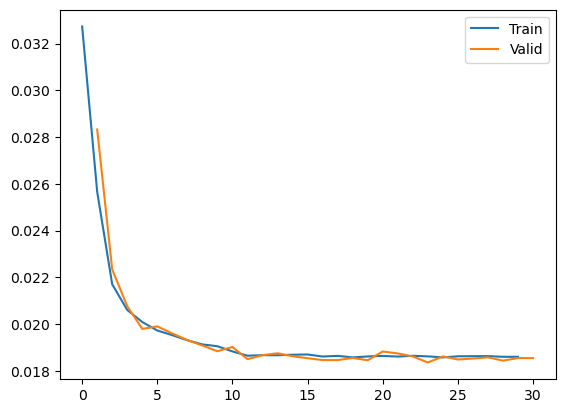

In [26]:
train_metrics = metrics['train']
val_metrics = metrics['valid']
plt.plot(range(len(train_metrics)), train_metrics, label='Train')
plt.plot(range(1, len(val_metrics) + 1), val_metrics, label='Valid')
plt.legend()
plt.show()